In [29]:
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
from getDistributions import csvFiles, L1metStr,L1njStr,L1pTj1Str,L1dPhi,L1metPartonStr,HLTnjStr,HLTpTj1Str,cols
import numpy as np
import logging
import sys,os
sys.path.append('../')
from helper import getModelDict

c = 3e8

FORMAT = '%(levelname)s: %(message)s at %(asctime)s'
logging.basicConfig(format=FORMAT,datefmt='%m/%d/%Y %I:%M:%S %p')
logger = logging.getLogger()

In [30]:
defaultPars = {'figure.figsize': (5, 4),
               'lines.markersize' : 4,
               'axes.titlesize' : 13,
               'font.size' : 13,
               'axes.labelsize' : 16,
               'xtick.labelsize' : 13,
               'ytick.labelsize' : 13,
               'legend.fontsize' : 10,
               "text.usetex": True,
               "font.family": "sans-serif",
               "font.sans-serif": ["Helvetica"],
               'font.family':'Times New Roman', 
               'font.serif':'Times New Roman',
               "savefig.dpi" : 300,
               'contour.linewidth' : 2.0,
               'lines.linewidth' : 2.0,
               'axes.grid' : True,
               'grid.linewidth' : 0.5,
               'grid.color' : 'lightgray',
               'axes.axisbelow' : True
               }
plt.rcParams.update(defaultPars)

### Results to be plotted

In [31]:
filesLabels = {
             'Signal' : 'ddmH_mS_500_m1_244_dm_90',
             'Signal\n(no smearing, no noise cut)'  : 'ddmH_mS_500_m1_244_dm_90_nosmear',
             }

### Get Model information

In [32]:
modelDict = {}
for label,csv_label in list(filesLabels.items()):
    csvFile = list(csvFiles.values())[0].replace('.csv', '_%s.csv' %csv_label)
    if not os.path.isfile(csvFile):
        print(f'File {csvFile} not found. Skipping.')
        filesLabels.pop(label)
    
    with open(csvFile,'r') as f:
        lines = f.readlines()
    rootFile = [l for l in lines[:10] if '.root' in l][0]
    rootFile = rootFile.split(':')[1].strip().split()[0]
    if not os.path.isfile(rootFile):
        print(f'File {rootFile} not found. Skipping.')
    else:
        modelDict[rootFile] = getModelDict(rootFile,verbose=False)

if len(set([tuple(d.items()) for d in modelDict.values()])) > 1:
    print('Several models being used!')
    mDict = None
else:
    mDict = list(modelDict.values())[0]

### Add Tobias curves

In [33]:
# tobiasCurves = {L1metStr : '../B2TF-Tobias/results/l1_met_new.csv',
#                 L1njStr : '../B2TF-Tobias/results/l1_nj_new.csv',
#                 L1pTj1Str : '../B2TF-Tobias/results/l1_et_new.csv',
#                 L1dPhi : '../B2TF-Tobias/results/l1_del_phi_new.csv',
#                 L1metPartonStr : '../B2TF-Tobias/results/l1_met_new.csv',

#                 HLTnjStr : '../B2TF-Tobias/results/offline_nj.csv',
#                 HLTpTj1Str : '../B2TF-Tobias/results/offline_pt.csv',
#                 }
# tobiasLabel = 'Signal-Tobias'


tobiasCurves = {L1metStr : '../B2TF-Tobias/results/l1_met_withoutNoiseCuts.csv',
                L1njStr : '../B2TF-Tobias/results/l1_nj_fixJets.csv',
                L1pTj1Str : '../B2TF-Tobias/results/l1_et_fixJets.csv',
                L1dPhi : '../B2TF-Tobias/results/l1_del_phi_fixJets.csv',
                L1metPartonStr : '../B2TF-Tobias/results/l1_met_withoutNoiseCuts.csv',

                HLTnjStr : '../B2TF-Tobias/results/offline_nj.csv',
                HLTpTj1Str : '../B2TF-Tobias/results/offline_pt.csv',
                }
tobiasLabel = 'Signal-Tobias\n (no noise cut + fix jets)'


## Plot Distributions

In [34]:
plot_variables = [c for c in cols if c not in ['label', L1metPartonStr]]

colors = dict(zip(filesLabels.keys(),plt.colormaps['Paired'].colors[1:2*len(filesLabels):2]))
colors[tobiasLabel] = plt.colormaps['Paired'].colors[2*len(filesLabels)+1]

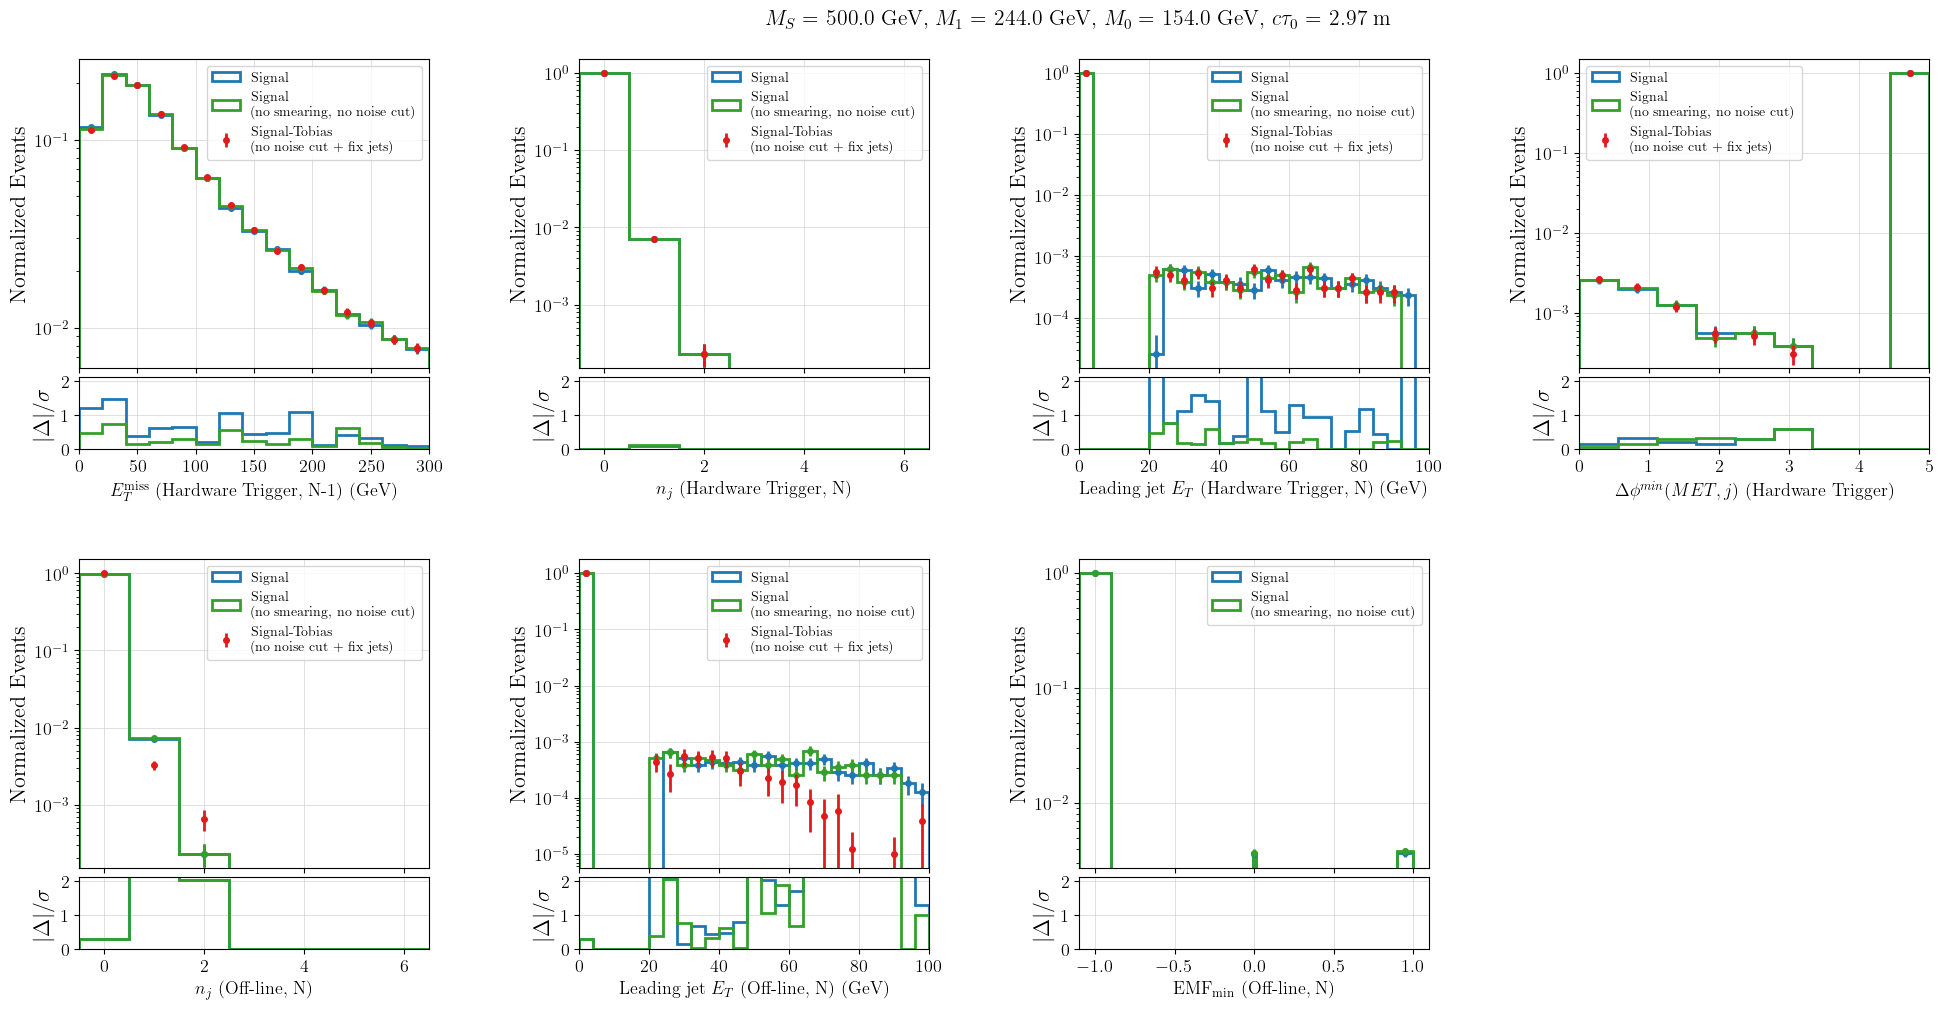

In [35]:
nrows = 2
ncols = int(np.ceil(len(plot_variables)/nrows))
# ncols = 4

# Create a figure for the nrows x ncols grid of plots
# Increased figsize to accommodate subplots
w,h = 5*ncols,5*nrows
fig = plt.figure(figsize=(w,h))

# Adjust overall subplot parameters
fig.subplots_adjust(hspace=0.4, wspace=0.3)

irow = 0
icol = 0
for i,var in enumerate(plot_variables):
    ymax = 0.0

    # Create a GridSpec for the current subplot cell.
    # This divides the current subplot space into 2 rows and 1 column,
    # with the top row 3 times taller than the bottom (for histogram vs ratio).
    gs = gridspec.GridSpec(2, 1, height_ratios=[3, 0.7                                                  ])
    # Place the gridspec within the overall figure grid using its position
    # For a nrows x ncols grid, (row, col) translates to (i // ncols, i % ncols) 0.7
    toppadding = 0.07 # space for title
    wpadding = 0.1 #width space between plots
    hpadding = 0.15 #height space between plots
    wspace = 1.0-wpadding*(ncols-1) # total width available for plots
    hspace = 1.0-toppadding-hpadding*(nrows-1) # total height available for plots
    gs.update(left=icol*(1.0/ncols),
                right=(icol)*(1.0/ncols) + wspace/ncols,
                top=1.0-toppadding - (irow)*(1.0/nrows),
                bottom=1.0-toppadding - (irow)*(1.0/nrows) -hspace/nrows,
                hspace=0.05) # No horizontal space between histogram and ratio within a cell

    icol += 1
    if icol == ncols:
        icol = 0
        irow += 1

    # Add the GridSpec to the main figure's grid
    # The `add_subplot` method takes GridSpec as an argument for placement
    ax_ratio = fig.add_subplot(gs[1, 0]) # Bottom part for ratio, sharing x-axis with ax_hist
    ax_hist = fig.add_subplot(gs[0, 0]) # Top part for histograms
    

 
    # Add Tobias curve if found
    y0 = None
    if var in tobiasCurves:
        tobiasData = np.genfromtxt(tobiasCurves[var],delimiter=',',names=True)
        ax_hist.errorbar(tobiasData['bin_center'],
                    tobiasData['normalized_count'],
                    tobiasData['error'],
                    linewidth=2,                    
                    fmt="o",
                    color=list(colors.values())[-1],
                    zorder=10,
                    label=tobiasLabel
                    )
        y0 = tobiasData['normalized_count']
        y0Err = tobiasData['error']
        bin_centers = tobiasData['bin_center']
        bins = list(tobiasData['bin_left_edge'])
        bins.append(tobiasData['bin_right_edge'][-1])


    for label,csv_label in filesLabels.items():
        if 'Signal' in label:
            ls = 'solid'
        else:
            ls = 'dashed'
        color = colors[label]
        csvFile = csvFiles[var].replace('.csv','_%s.csv'%csv_label)
        data = np.genfromtxt(csvFile,
                             delimiter=',',comments='#',names=True,skip_header=2)
        y = data['normalized_count']
        yerr = data['error']
        bin_centers = data['bin_center']
        bins = list(data['bin_left_edge'])
        bins.append(data['bin_right_edge'][-1])

        _,_,p = ax_hist.hist(bin_centers,weights=y,bins=bins,histtype='step',
                linewidth=2,linestyle=ls,label=label,color=color)
        ax_hist.errorbar(bin_centers,y,yerr = yerr,
                        # marker = '.',
                        color=color,
                        # color=p[-1].get_facecolor(),
                        # drawstyle = 'steps-mid',label=label,
                        linewidth=2,
                        # linestyle=ls,
                        fmt="o")
        
    
        # Plot ratios
        # r_y = np.divide(y,y0)
        # r_error = r_y*np.sqrt((yerr/y)**2 + (y0Err/y0)**2)
        # ax_ratio.errorbar(bin_centers,r_y,yerr = r_error,marker = '.',drawstyle = 'steps-mid',
        #             label=label,linewidth=2,linestyle=ls,color=color)
        # Plot diff
        if y0 is not None:
            dy = y-y0
            dy_error = np.sqrt(yerr**2 + y0Err**2)
            ddy = np.abs(np.divide(dy, dy_error, out=np.zeros_like(dy_error), where= dy_error != 0))
            # ddy = np.array([dy[i]/dyerr for i,dyerr in enumerate(dynp.where(dy_error > 0., dy/dy_error,0.0)
            ax_ratio.hist(bin_centers,weights=ddy,bins=bins,histtype='step',
                            linewidth=2,linestyle=ls,label=label,color=color)
    

    
        
    
    ax_hist.set_ylabel('Normalized Events')
    ax_hist.set_xticklabels([])
    ax_hist.set_yscale('log')
    ax_hist.set_xlim(min(bins),max(bins))
    if i >= 0:
        ax_hist.legend()

    ax_ratio.set_xlabel(var,fontsize=13)
    ax_ratio.set_ylabel(r'$|\Delta|/\sigma$')
    ax_ratio.set_yticks([0.0,1.0,2.0])
    ax_ratio.set_ylim(0.0,2.1)
    ax_ratio.set_xlim(min(bins),max(bins))
    

if mDict:
    fig.suptitle(r"$M_{S} =$ %1.1f GeV, $M_{1} = $ %1.1f GeV, $M_0 = $ %1.1f GeV, $c \tau_0$ = %1.2f m" %(mDict['mS'],mDict['m1'],mDict['m0'],c*mDict['tau']))

plt.show()